# Springboard Capestone Project -- Financial Sentimential Analysis and Timeseries Processing

<a id='toc'></a>
## Table of Content
1. [Intro](#intro)
2. [Import and Initialization](#init)
3. [Load Data](#load)
    * [sentimential140](#sent140)
    * [multidomain_dataset](#amzn)
    * [stock tweets](#stktws)
    * [phraseBank-v1.0](#phbank)
    * [us_equitie_dataset](#equitie)
    * [reuters_news](#rt_news)
4. [Clean Data](#clean)
    * [Clean Sentimential140](#clean_sent140)
    * [Clean Multidomain_dataset](#clean_amzn)
    * [Clean_stock tweets](#clean_stktws)
    * [Clean_phraseBank-v1.0](#clean_phbank)
    * [Clean_us_equitie_dataset](#clean_equitie)
    * [Clean_reuters_news](#clean_rt_news)
5. [Dataset Split](#split)
6. [Generate embedding](#embedding)

    6.1 [traditional approachs](#traditional)
    * [bow](#bow)
    * [tf-idf](#tf-idf) 
    
   6.2 [DL approaches](#dl)
    * [word2vec](#w2v)
    * [glove](#glove)
    * [elmo](#elmo)
7. [Classifier](#classifier)

    7.1 [traditional classifiers](#classifier_trad)
    * [Bernoulli Naive Bayes](#bayes)
    * [Logistic Regression](#lr)
    * [Support Vector Machine](#svm) 
    
   7.2 [DL classifiers](#classifier_dl)
    * [LSTM classifier with GloVe embedding](#dl_glove)
    * [LSTM classifier with ELMo embedding](#dl_elmo)
    * [ULFit classifier](#dl_ufit)
    * [FinBERT](#finbert)

<a id='intro'></a>
## 1. Intro
[back to table of contents](#toc)

<a id='init'></a>
## 2. Import & Initialization
[back to table of contents](#toc)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import os

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
base_path = '/content/drive/My Drive/Colab/cp/'

<a id='load'></a>
## 3. Load Data

Generally, we will load 4 different dataset: 
* [sentimential140](http://help.sentiment140.com/for-students/) from Stanford University, contains 160,000 labeled tweets (in-use)
* [Multidomain SA dataset](http://www.cs.jhu.edu/~mdredze/datasets/sentiment/), from JHU, contains Amazon product reviews from (in-use)
* [stocktweets](https://www.kaggle.com/vivekrathi055/sentiment-analysis-on-financial-tweets), financial content from verified tweet accounts. Already preprocessed. (in-use)
* [phraseBnak](https://www.researchgate.net/publication/251231364_FinancialPhraseBank-v10), this is well labeled dataset by financial pro. (in-use)
* [stock_data](https://www.kaggle.com/yash612/stockmarket-sentiment-dataset), Negative count: 2,106, Positive count: 3,685 (prepared)

* [US_financial_News](https://www.kaggle.com/jeet2016/us-financial-news-articles), no labeled data (prepared)
* [us_equities_news_dataset](https://www.kaggle.com/gennadiyr/us-equities-news-data) (in-use)
* [Reuters Article](https://www.kaggle.com/miguelaenlle/reuters-articles-for-3500-stocks-since-2017), for 3500+ stocks since 2017 (in-use)

[back to table of contents](#toc)

<a id='sent140'></a>
### 3.1 sentiment140 dataset
1. we load the dataset from local csv file.
2. After that, we count the label values and convert the label to 0, 1
3. Then we check the text length, we found that the length is between 6~374. But twetter doesn't allow text length beyond 280, we found there are some characters which was mis decoded.
4. we try to clean the dataset

[back to table of contents](#toc)

In [ ]:
sentiment140_path = 'data/training.1600000.processed.noemoticon.csv'
# sentiment140 = pd.read_csv(sentiment140_path, 
#                            encoding='ISO-8859-1',
#                            names=['polarity', 'id', 'date', 'query', 'user', 'text'],
#                            dtype={'date': datetime})
sentiment140 = pd.read_csv(sentiment140_path, 
                           encoding='latin-1',
                           names=['label', 'id', 'date', 'query', 'user', 'text'])
sentiment140.info()

In [ ]:
len(sentiment140.text.unique())

In [ ]:
# convert the label to 0, 1
sentiment140.loc[(sentiment140['label'] == 4), 'label'] = 1

In [ ]:
sentiment140.label.value_counts(), len(sentiment140.user.unique())

In [ ]:
sentiment140.iloc[-5:]

In [ ]:
sentiment140['pre_clean_len'] = sentiment140.text.apply(len)
sentiment140.pre_clean_len.sort_values()

In [ ]:
plt.boxplot(sentiment140.pre_clean_len)

In [ ]:
sentiment140.loc[sentiment140.pre_clean_len>140]

In [ ]:
# remove @
t = re.sub(r'^@[a-zA-Z0-9]+', '', sentiment140.iloc[343].text)
print(t)
sentiment140.iloc[343].text

# remove html tag
t = BeautifulSoup(t, 'html5lib').get_text()
print(t)

# remove http link
t = re.sub(r'https?://[a-zA-Z0-9./]+', '', sentiment140.loc[0].text)
print(t)

# convert unicode
sentiment140.iloc[1295281]['text']


In [ ]:
p1 = r'^@[a-zA-Z0-9]+'
p2 = r'https?://[a-zA-Z0-9./]+'
pattern = r'|'.join([p1, p2])
tok = WordPunctTokenizer()

def clean_tw(text):
    clean_text = BeautifulSoup(text, 'html5lib').get_text()
    clean_text = re.sub(pattern, '', clean_text)
    clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_text)
    
    clean_text = clean_text.lower()
    tokens = tok.tokenize(clean_text)
    return (' '.join(tokens)).strip()
    
    
testing = sentiment140.text[:10]
test_result = []
for t in testing:
    test_result.append(clean_tw(t))
test_result

<a id='amzn'></a>
### 3.2 Multidomain_SA: Amazon Product Reviews
1. we load the dataset from local csv file. files are separated in different folders according to the category of products
2. I try to use lxml or xml library, but there is some abnormal tag, so it always issues error.
3. I resolve the raw file by tag information
4. compare the total number of pos-neg review with original summary.txt

[back to table of contents](#toc)

In [2]:
from lxml import etree

amzn_path = '/Users/zz/Documents/dev/Springboard/data/raw/multidomain_SA/sorted_data'
pos_file_name = 'positive.review'
neg_file_name = 'negative.review'

folders = os.listdir(amzn_path)
num_folder = len(folders)
count = 0

# define corpus dataframe
multidomain = pd.DataFrame(columns=['text', 'target'])
total_count = 0
folder_count = 0

print('[INFO] start processing multidomain files...')
for fold in folders:
    file_path = os.path.join(amzn_path, fold)
    if os.path.isdir(file_path):
        folder_count += 1
        
        pos_file = os.path.join(file_path, pos_file_name)
        neg_file = os.path.join(file_path, neg_file_name)
        
        with open(pos_file, 'r', encoding='latin-1') as f:
            pos = f.readlines()

        with open(neg_file, 'r', encoding='latin-1') as f:
            neg = f.readlines()

        # process positive review
        corpus_pos = []
        flag = False
        for i in range(len(pos)):
            if pos[i] == '<review_text>\n':
                flag = True
                new_str = ''
                continue
            elif pos[i] == '</review_text>\n':
                flag =False
                corpus_pos.append(new_str)
                continue
            if (flag):
                if len(pos[i]) > 1:
                    sent = pos[i]
                    sent = sent[0:len(sent)-1]
                    if sent[0] == '\t':
                        sent = sent[1:len(sent)-1]
                new_str += sent

        # process negative review
        corpus_neg = []
        flag = False
        for i in range(len(neg)):
            if neg[i] == '<review_text>\n':
                flag = True
                new_str = ''
                continue
            elif neg[i] == '</review_text>\n':
                flag = False
                corpus_neg.append(new_str)
                continue
            if flag:
                if len(neg[i]) > 1:
                    sent = neg[i]
                    sent = sent[0:len(sent)-1]
                    if sent[0] == '\t':
                        sent = sent[1:len(sent)-1]
                new_str += sent

        pos_df = pd.DataFrame(corpus_pos, columns=['text'])
        pos_df['target'] = 1

        neg_df = pd.DataFrame(corpus_neg, columns=['text'])
        neg_df['target'] = 0

        multidomain = pd.concat([multidomain, neg_df, pos_df])
        total_count += neg_df.shape[0] + pos_df.shape[0]
        
        count += 1
        print('[INFO] finish processing {} / totoal {}'.format(count, num_folder))

#         print('folder {} contains: pos_df is {} rows, neg_df is {} rows'.format(file_path, 
#                                                                                 pos_df.shape[0], 
#                                                                                 neg_df.shape[0]))
multidomain.reset_index(drop=True, inplace=True)
print('Total folders are {}, the number of corpus is {}'.format(folder_count, total_count))

[INFO] start processing multidomain files...
[INFO] finish processing 1 / totoal 27
[INFO] finish processing 2 / totoal 27
[INFO] finish processing 3 / totoal 27
[INFO] finish processing 4 / totoal 27
[INFO] finish processing 5 / totoal 27
[INFO] finish processing 6 / totoal 27
[INFO] finish processing 7 / totoal 27
[INFO] finish processing 8 / totoal 27
[INFO] finish processing 9 / totoal 27
[INFO] finish processing 10 / totoal 27
[INFO] finish processing 11 / totoal 27
[INFO] finish processing 12 / totoal 27
[INFO] finish processing 13 / totoal 27
[INFO] finish processing 14 / totoal 27
[INFO] finish processing 15 / totoal 27
[INFO] finish processing 16 / totoal 27
[INFO] finish processing 17 / totoal 27
[INFO] finish processing 18 / totoal 27
[INFO] finish processing 19 / totoal 27
[INFO] finish processing 20 / totoal 27
[INFO] finish processing 21 / totoal 27
[INFO] finish processing 22 / totoal 27
[INFO] finish processing 23 / totoal 27
[INFO] finish processing 24 / totoal 27
[INF

In [3]:
# check the number, compare with summary.txt
t = 0
t2 = []

with open((amzn_path + '/summary.txt'), 'r', encoding='utf-8') as f:
    summary = f.readlines()
for l in summary:
    n = l.split()[-1]
    t2.append([l.split()[-2].split('/')[-1], int(l.split()[-1])])
    s = l.split()[-2][-15:]
    if s not in ['negative.review', 'positive.review']:
        continue
    else:
#         print('string {}, contains {}'.format(s, n))
        t += int(n)

df_df = pd.DataFrame(t2, columns=['name', 'num'])
# print('df_df group infor:\n', df_df.groupby(by='name').sum())
print('df_df neg-pos total number: ', df_df[df_df['name'] != 'unlabeled.review'].num.sum())
# print('processed dataset neg-pos total num:\n', multidomain.target.value_counts())

df_df neg-pos total number:  38548


In [5]:
multidomain['pre_clean_len'] = multidomain.text.apply(len)
multidomain.pre_clean_len.sort_values()

13164        3
14300        6
21994        7
658          9
15574       10
         ...  
11673    25472
15430    37105
21754    46259
18004    53975
13948    64047
Name: pre_clean_len, Length: 38548, dtype: int64

In [6]:
multidomain.head()

,text,target,pre_clean_len
0,I've always held the philosophy you are what y...,0,3933
1,someone get this band a producer and put them ...,0,565
2,Tihs Album is not all that good when it came o...,0,218
3,"this industry is ""goin down"" this industry is...",0,87
4,I'm sorry but the guy below me doesn't know mu...,0,269


In [8]:
multidomain.to_csv(('/Users/zz/Documents/dev/Springboard/data/interim/' + 'multidomain_raw.csv'), index=0, sep="|")

<a id='stktws'></a>
### 3.3 Stock_Tweets: Twitter content from verified account concerning stock news, with sentimential label
1. we load the dataset from local csv file. files are already preprocessed, can directly apply for analysis.
2. label is self-scored from nltk, so it's not reliable.
3. 1: positive; -1: negative; 0: neutral
4. can be used as non-labeled data, tested in DL approach

[back to table of contents](#toc)

In [ ]:
tweet_sentim_path = 'data/tweet_sentiment/tweet_sentiment.csv'
tweet_sentim_df = pd.read_csv(tweet_sentim_path)

In [ ]:
tweet_sentim_df.columns = ['text', 'target']
# tweet_sentim_df.loc[(tweet_sentim_df['target'] == 0), 'target'] = 1
tweet_sentim_df.target.value_counts()

In [ ]:
# cal text len, and drop Nan and rows with len<10

tweet_sentim_df.dropna(inplace=True)
tweet_sentim_df['pre_clean_len'] = tweet_sentim_df.text.apply(len)
tweet_sentim_df.pre_clean_len.sort_values()
tweet_sentim_df = tweet_sentim_df[tweet_sentim_df.pre_clean_len > 10]

<a id='phbank'></a>
### 3.4 Phrase_Bank: high quality financial dataset with label by financial professional 
1. we load the dataset from local csv file. files are already preprocessed, can directly apply for analysis.
2. dataset was labeled by financial professional, reliable.
3. using @positive, @negative @ neutral at the end of each text
4. 

[back to table of contents](#toc)

In [15]:
phasbank_p100_path = '/Users/zz/Documents/dev/Springboard/data/raw/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt'
phasbank_p75_path = '/Users/zz/Documents/dev/Springboard/data/raw/FinancialPhraseBank-v1.0/Sentences_75Agree.txt'

# with 100% agree dataset
with open(phasbank_p100_path, 'r', encoding='latin-1') as f:
    lines = f.readlines()

corpus = []
target = []
for line in lines:
    if len(line.split('@')) == 2:
        text = line.split('@')[0]
        corpus.append(text)
        label = line.split('@')[1].strip()
        target.append(label)
        
#         if label.lower() == 'positive':
#             target.append(1)
#         elif label.lower() == 'negative':
#             target.append(-1)
#         else:
#             target.append(0)
            
print('total lines: {}; the df_p100 shape is {}'.format(len(lines), (len(corpus), len(target))))
phasbank_p100 = pd.DataFrame(list(zip(corpus, target)), columns=['text', 'target'])
phasbank_p100.loc[phasbank_p100['target'] == 'positive', 'target'] = 1
phasbank_p100.loc[phasbank_p100['target'] == 'negative', 'target'] = 0
phasbank_p100.loc[phasbank_p100['target'] == 'neutral', 'target'] = -1

# 75% agree
with open(phasbank_p75_path, 'r', encoding='latin-1') as f:
    lines = f.readlines()

corpus = []
target = []
for line in lines:
    if len(line.split('@')) == 2:
        text = line.split('@')[0]
        corpus.append(text)
        label = line.split('@')[1].strip()
        target.append(label)
        
#         if label.lower() == 'positive':
#             target.append(1)
#         elif label.lower() == 'negative':
#             target.append(-1)
#         else:
#             target.append(0)
            
print('total lines: {}; the df_p75 shape is {}'.format(len(lines), (len(corpus), len(target))))
phasbank_p75 = pd.DataFrame(list(zip(corpus, target)), columns=['text', 'target'])
phasbank_p75.loc[phasbank_p75['target'] == 'positive', 'target'] = 1
phasbank_p75.loc[phasbank_p75['target'] == 'negative', 'target'] = 0
phasbank_p75.loc[phasbank_p75['target'] == 'neutral', 'target'] = -1

total lines: 2264; the df_p100 shape is (2264, 2264)
total lines: 3453; the df_p75 shape is (3453, 3453)


In [16]:
phasbank_p100 = phasbank_p100.astype({'target': 'int32'})
phasbank_p75 = phasbank_p75.astype({'target': 'int32'})
phasbank_p100.info(), phasbank_p75.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2264 non-null   object
 1   target  2264 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 26.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3453 non-null   object
 1   target  3453 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 40.6+ KB


(None, None)

In [17]:
phasbank_p100.target.value_counts(), phasbank_p75.target.value_counts()

(-1    1391
  1     570
  0     303
 Name: target, dtype: int64,
 -1    2146
  1     887
  0     420
 Name: target, dtype: int64)

In [25]:
phasbank_raw = pd.concat([phasbank_p100, phasbank_p75])
phasbank_raw = phasbank_raw[phasbank_raw['target'] != -1]
phasbank_raw['pre_clean_len'] = phasbank_raw.text.apply(len)
phasbank_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2180 entries, 1 to 3452
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           2180 non-null   object
 1   target         2180 non-null   int32 
 2   pre_clean_len  2180 non-null   int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 59.6+ KB


In [29]:
phasbank_raw[phasbank_raw.pre_clean_len<30]

,text,target,pre_clean_len
142,Cargo volume grew by 7 % .,1,26


In [30]:
phasbank_raw.loc[142]

,text,target,pre_clean_len
142,"Kesko Agro Eesti , the retailer and wholesaler...",1,209
142,Cargo volume grew by 7 % .,1,26


In [13]:
phasbank_raw.to_csv(('/Users/zz/Documents/dev/Springboard/data/interim/' + 'phasbank_raw.csv'), 
                    index=0, 
                    sep="|")

<a id='equitie'></a>
### 3.5 US Equitie Dataset: 
1. we load the dataset from local csv file.
2. no labeled

[back to table of contents](#toc)

In [ ]:
us_equitie_path = 'data/us_equities_news_dataset.csv'

us_equitie_df = pd.read_csv(us_equitie_path)
us_equitie_df.head()

In [ ]:
us_equitie_df = us_equitie_df[~(us_equitie_df['content'].isna())]
us_equitie_df.info()

In [ ]:
# investigate
us_equitie_df['release_date'] = pd.to_datetime(us_equitie_df.release_date)
# plt.hist(us_equitie_df.release_date.value_counts())
us_equitie_df.provider.value_counts()

In [ ]:
us_equitie_df = us_equitie_df[['content']]
us_equitie_df

<a id='rt_news'></a>
### 3.6 Reuters  Equitie Dataset: 
1. we load the dataset from local csv file.
2. the labeled is cal by using NLTK's VADER Sentiment Intensity Anayzer.


[back to table of contents](#toc)

In [ ]:
rt_news_path = 'data/reuters_data.csv'

rt_news = pd.read_csv(rt_news_path)
rt_news.info()

In [ ]:
rt_news.head()

In [ ]:
rt_news = rt_news[['processed_header', 'full_article']]

In [ ]:
rt_news['text'] = rt_news.full_article.apply(lambda x: x.split('-')[-1])

In [ ]:
rt_news.drop(['full_article'], axis=1, inplace=True)
rt_news.head()

In [ ]:
rt_news['pre_clean_len'] = rt_news.text.apply(len)

In [ ]:
rt_news.pre_clean_len.value_counts()

<a id='clean'></a>
## 4. Clean Data
[back to table of contents](#toc)

In [243]:
import unicodedata

# !pip install contractions
from contractions import contractions_dict
import spacy
import nltk
from nltk.tokenize import ToktokTokenizer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/zz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [244]:
# nlp = en_core_web_md.load(disable=['parse', 'tag', 'entiry'])
nlp = spacy.load('en_core_web_md', disable=['parse', 'tag', 'entiry'])
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

# hash tag and http link
p1 = r'^@[a-zA-Z0-9]+'
p2 = r'https?://[a-zA-Z0-9./]+'
pattern = r'|'.join([p1, p2])

# clean html tag
def strip_html_tags(text):
    soup = BeautifulSoup(text, 'lxml')
    stripped_text = soup.get_text()
    return stripped_text

def remove_hash_tag_link(text):
    text = re.sub(pattern, '', text)
    return text

# removing accented character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

# expanding contractions
def expand_contractions(text, contraction_mapping=contractions_dict):
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) \
                                if contraction_mapping.get(match) \
                                else contraction_mapping.get(match.lower())
        if expanded_contraction:
            expanded_contraction = first_char + expanded_contraction[1:]
        else:
            expanded_contraction = match
        return expanded_contraction
    
    contraction_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                     flags=re.IGNORECASE|re.DOTALL)
    expanded_text = contraction_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", " ", expanded_text)
    return expanded_text

# remove special characters
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# lemmztizing text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# remove stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


# put it together
def normalize_corpus(corpus, html_stripping=True, hash_link=True,
                     contraction_expansion=True, accented_char_removal=True, 
                     text_lower_case=True, text_lemmatization=True, 
                     special_char_removal=True, stopword_removal=True):
    normalized_corpus = []
    
    for doc in corpus:
        if html_stripping:
            doc = strip_html_tags(doc)
        if hash_link:
            doc = remove_hash_tag_link(doc)
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        if contraction_expansion:
            doc = expand_contractions(doc)
        if text_lower_case:
            doc =doc.lower()
        
        doc = re.sub(r'[\r|\n|\r\n]+', ' ', doc)
        
        # insert spaces between special characters to isolate them
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        
        if text_lemmatization:
            doc = lemmatize_text(doc)
        if special_char_removal:
            doc = remove_special_characters(doc)
        
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        
        normalized_corpus.append(doc)
        
    return normalized_corpus 

In [ ]:
# test
x = [sentiment140['text'].loc[2]]
print(x)
print(normalize_corpus(x, stopword_removal=False, text_lemmatization=False))
len(sentiment140.text)

<a id='clean_sent140'></a>
### 4.1 Clean Sentimential140 
* twetter dataset
* remove html_tag -> hash_tag_link -> accented_char -> contraction_expand -> lower -> special_char
* save in file 'sentimential140_cleaned.csv'

[back to table of contents](#toc)

In [ ]:
cleaned_tw_text = []
total = len(sentiment140)
batch_size = total // 20

for i in range(0, total, batch_size):
    print('Tweets %d of %d has been processed' % ( i+1, total))
    batch_corpus = sentiment140['text'].iloc[i:i+batch_size].values
    cleaned_tw_text.extend(normalize_corpus(batch_corpus, stopword_removal=False, text_lemmatization=False))

In [ ]:
clean_sent140_df = pd.DataFrame(cleaned_tw_text, columns=['text'])
clean_sent140_df['target'] = sentiment140['label'].values
clean_sent140_df.head(), clean_sent140_df.info()

In [ ]:
clean_sent140_df.to_csv('sentimential140_cleaned.csv', encoding='utf-8')

<a id='clean_amzn'></a>
### 4.2 Clean Multidomain Dataset
* amazon product reviews dataset
* remove html_tag -> hash_tag_link -> accented_char -> contraction_expand -> lower -> special_char
* save in file 'multidomain_cleaned.csv'

[back to table of contents](#toc)

In [ ]:
# drop short review, <18 characters
multidomain = multidomain.loc[multidomain.pre_clean_len >= 18]
multidomain.info()

In [ ]:
texts = multidomain.loc[:, 'text']
total = len(texts)
print(total)
cleaned_text = []

print('[INFO] start processing multidomain text')
cleaned_text.extend(normalize_corpus(texts, 
                                     html_stripping=False,
                                     text_lemmatization=False))

In [ ]:
cleaned_multidomain_df = pd.DataFrame(cleaned_text, columns=['text'])
cleaned_multidomain_df['target'] = multidomain['target'].values
cleaned_multidomain_df.head(), cleaned_multidomain_df.info()

In [ ]:
cleaned_multidomain_df.to_csv('multidomain_cleaned.csv', encoding='utf-8')

In [ ]:
# prepare to use for ELMo 
texts = multidomain.loc[:, 'text']
total = len(texts)
print(total)
cleaned_text = []

print('[INFO] start processing multidomain text')
cleaned_text.extend(normalize_corpus(texts, 
                                     html_stripping=False,
                                     special_char_removal=False))

cleaned_multidomain_df = pd.DataFrame(cleaned_text, columns=['text'])
cleaned_multidomain_df['target'] = multidomain['target'].values
cleaned_multidomain_df.head(), cleaned_multidomain_df.info()

cleaned_multidomain_df.to_csv('multidomain_cleaned_with_spec_char.csv', encoding='utf-8')

In [ ]:
# prepare for ELMo, preserve the special character
texts = multidomain.loc[:, 'text']

total = len(texts)

print(total)
cleaned_text = []

print('[INFO] start processing...')
for line in texts:
    line = line.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0', ' ').replace('%', 'percent')
    line = re.sub(pattern, ' millions ', line)
    line = ' '.join(line.split())
    doc = nlp(line)
    
    sentences = []
    for i in doc.sents:
        if len(i)>1:
            sentences.append(i.string.strip())

    cleaned_text.append(sentences)
print('[INFO] finish processing..., total {} lines'.format(len(cleaned_text)))

<a id='clean_stktws'></a>
### 4.3 Clean Stock Tweets Dataset
* Stock Tweets dataset
* remove html_tag -> hash_tag_link -> accented_char -> contraction_expand -> lower -> special_char
* save in file 'stktws_cleaned.csv'

[back to table of contents](#toc)

In [ ]:
tweet_sentim_df.info()

In [ ]:
texts = tweet_sentim_df.loc[:, 'text']
total = len(texts)

print(total)
cleaned_text = []

print('[INFO] start processing...')
cleaned_text.extend(normalize_corpus(texts, 
                                     html_stripping=False, 
                                     stopword_removal=False, 
                                     text_lemmatization=False))
print('[INFO] finish processing...total {}'.format(len(cleaned_text)))

In [ ]:
cleaned_tw_df = pd.DataFrame(cleaned_text, columns=['text'])
cleaned_tw_df['target'] = tweet_sentim_df['target'].values
cleaned_tw_df.head(), cleaned_tw_df.info()

In [ ]:
cleaned_tw_df.to_csv('stktws_cleaned.csv', encoding='utf-8')

<a id='clean_phbank'></a>
### 4.4 Clean PhaseBank Dataset
* PhraseBank dataset
* remove html_tag -> hash_tag_link -> accented_char -> contraction_expand -> lower -> special_char
* save in file 'phasbank_cleaned.csv'

[back to table of contents](#toc)

In [214]:
texts = pd.concat([phasbank_p100, phasbank_p75]).text

total = len(texts)

print(total)
cleaned_text = []

print('[INFO] start processing...')
cleaned_text.extend(normalize_corpus(texts, 
                                     html_stripping=False))
print('[INFO] finish processing, total {}'.format(len(cleaned_text)))

5717
[INFO] start processing...


TypeError: normalize_document() got an unexpected keyword argument 'html_stripping'

In [ ]:
cleaned_phasbank_df = pd.DataFrame(cleaned_text, columns=['text'])
cleaned_phasbank_df['target'] = pd.concat([phasbank_p100, phasbank_p75]).target.values
cleaned_phasbank_df.head(), cleaned_phasbank_df.info()

In [ ]:
cleaned_phasbank_df.to_csv('phasbank_cleaned.csv', encoding='utf-8')

In [ ]:
cleaned_text[:10]

<a id='clean_equitie'></a>
### 4.5 Clean US Equities Dataset
* US Equities dataset
* remove html_tag -> hash_tag_link -> accented_char -> contraction_expand -> lower -> special_char
* save in file 'us_equitie_cleaned.csv'

[back to table of contents](#toc)

In [ ]:
texts = us_equitie_df.content
total = len(texts)
batch_size = total // 10

print(total)
cleaned_text = []

print('[INFO] start processing...')
for i in range(0, total, batch_size):
    
    # cleaned_text.extend(normalize_corpus(texts))
    print('[INFO] processing, {} in total {}'.format(i+1, total))
    batch_corpus = texts[i : min(i+batch_size, total)].values
    cleaned_text.extend(normalize_corpus(batch_corpus))

print('[INFO] finish processing, total {}'.format(len(cleaned_text)))

In [ ]:
len(cleaned_text)

In [ ]:
# no labeled dataset
cleaned_us_equitie_df = pd.DataFrame(cleaned_text, columns=['text'])
cleaned_us_equitie_df.head(), cleaned_us_equitie_df.info()

In [ ]:
cleaned_us_equitie_df.to_csv('clean_us_equitie.csv', encoding='utf-8')

<a id='clean_rt_news'></a>
### 4.6 Clean Reuters News Dataset
* Reuters News dataset
* remove html_tag -> hash_tag_link -> accented_char -> contraction_expand -> lower -> special_char
* save in file 'rt_news_cleaned.csv'

[back to table of contents](#toc)

In [ ]:
import time

texts = rt_news.text
header = rt_news.processed_header

total = len(texts)
batch_size = total // 10
print(total)

cleaned_header_corpus = []
cleaned_text_corpus = []

print('[INFO] start processing text...')
for i in range(0, total, batch_size):
    start = time.time()
    batch_text = texts[i : min(i+batch_size, total)]
    cleaned_text_corpus.extend(normalize_corpus(batch_text))
    
    batch_header = header[i : min(i+batch_size, total)]
    cleaned_header_corpus.extend(normalize_corpus(batch_header))
    end = time.time()
    print('[INFO] processing {}s, {} in total {}'.format((start-end), i+1, total))

print('[INFO] processing fininsh, total {}'.format(len(cleaned_text_corpus)))

In [ ]:
cleaned_rt_news_df = pd.DataFrame(list(zip(cleaned_text_corpus, cleaned_header_corpus)), 
                                  columns=['text', 'header'])
cleaned_rt_news_df.head(), cleaned_rt_news_df.info()

In [ ]:
cleaned_rt_news_df.to_csv('rt_news_cleaned.csv', encoding='utf-8')

<a id='split'></a>
## 5. Dataset Split

[back to table of contents](#toc)

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import os

%matplotlib inline

In [216]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec
import nltk
from sklearn.manifold import TSNE

In [217]:
cleaned_multidomain_df = pd.read_csv('multidomain_cleaned.csv')
texts = cleaned_multidomain_df.text
target = cleaned_multidomain_df.target

X_train_md, X_test_md, y_train_md, y_test_md = train_test_split(texts, 
                                                                target,
                                                                random_state=42,
                                                                test_size=0.3)
print(X_train_md.shape, X_test_md.shape)

(26980,) (11563,)


In [218]:
target.value_counts(), y_train_md.value_counts(), y_test_md.value_counts()

(1    21970
 0    16573
 Name: target, dtype: int64,
 1    15309
 0    11671
 Name: target, dtype: int64,
 1    6661
 0    4902
 Name: target, dtype: int64)

In [219]:
cleaned_phasbank_df = pd.read_csv('phasbank_cleaned.csv', encoding='utf-8')

# ignore neutral classes
cleaned_phasbank_df_abs = cleaned_phasbank_df.loc[cleaned_phasbank_df.target != 0]
print(cleaned_phasbank_df_abs.shape)

texts = cleaned_phasbank_df_abs.text
target = cleaned_phasbank_df_abs.target



X_train_pb, X_test_pb, y_train_pb, y_test_pb = train_test_split(texts, 
                                                                target,
                                                                random_state=42,
                                                                test_size=0.3)
print(X_train_pb.shape, X_test_pb.shape)

(4994, 3)
(3495,) (1499,)


In [220]:
target.value_counts(), y_train_pb.value_counts(), y_test_pb.value_counts()

(-1    3537
  1    1457
 Name: target, dtype: int64,
 -1    2482
  1    1013
 Name: target, dtype: int64,
 -1    1055
  1     444
 Name: target, dtype: int64)

<a id='embedding'></a>
## 6. Word Embedding

[back to table of contents](#toc)

<a id='traditional'></a>
### 6.1 Traditional Approaches
[back to table of contents](#toc)

<a id='bow'></a>
* bow 
* using multidomain and PhaseBank dataset
* generate 1-gram, bi-gram; ti-gram embeddings

[back to table of contents](#toc)

In [96]:
# using min_df to ignore lower frequency word, 
# it's not applicable for review, which language is not a formal language 
# cv = CountVectorizer(min_df=0.01)
# len(cv.vocabulary_)  Out[85]: 894
cv = CountVectorizer()
cv.fit(X_train_md)

print(len(cv.vocabulary_))

X_train_vec_bow_md = cv.transform(X_train_md)
X_test_vec_bow_md = cv.transform(X_test_md)

74454


In [101]:
len(X_train_vec_bow_md.toarray()[0])

74454

In [8]:
neg_md_mat = cv.transform(cleaned_multidomain_df[cleaned_multidomain_df.target == 0].text)
pos_md_mat = cv.transform(cleaned_multidomain_df[cleaned_multidomain_df.target == 1].text)

neg_tf = np.sum(neg_md_mat, axis=0)
pos_tf = np.sum(pos_md_mat, axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos], columns=cv.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df.negative + term_freq_df.positive

term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
not,38527,34036,72563
one,10569,13748,24317
would,10251,9020,19271
like,8331,10757,19088
get,6761,7569,14330
good,5259,8574,13833
great,3236,10537,13773
no,6639,6365,13004
time,5521,6994,12515
use,4080,7047,11127


Text(0.5, 1.0, 'Top 50 negative tokens')

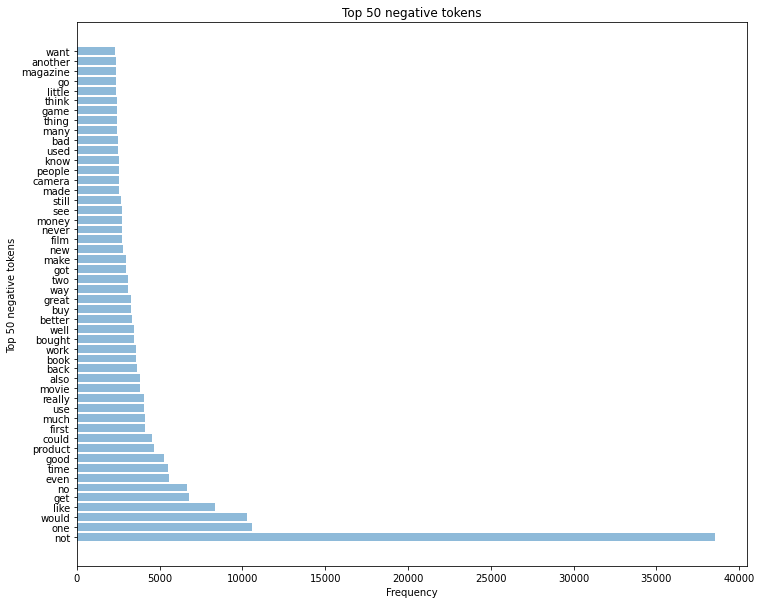

In [9]:
y_pos = np.arange(50)

neg_df = term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50]

plt.figure(figsize=(12, 10))
plt.barh(y_pos,
         neg_df,
         align='center',
         alpha=0.5)
plt.yticks(y_pos,
           neg_df.index)

# plt.invert_yaxis()
plt.xlabel('Frequency')
plt.ylabel('Top 50 negative tokens')
plt.title('Top 50 negative tokens')

Text(0.5, 1.0, 'Top 50 positive tokens')

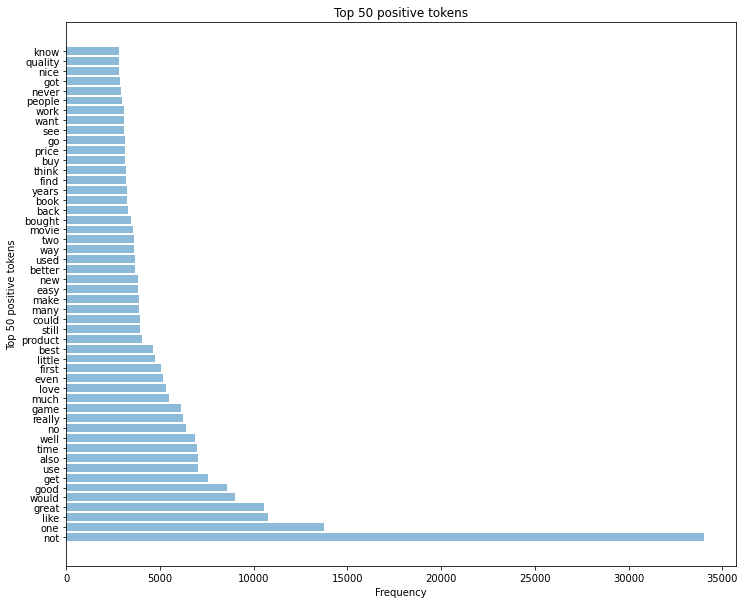

In [10]:
y_pos = np.arange(50)

pos_df = term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50]

plt.figure(figsize=(12, 10))
plt.barh(y_pos,
         pos_df,
         align='center',
         alpha=0.5)
plt.yticks(y_pos,
           pos_df.index)

# plt.invert_yaxis()
plt.xlabel('Frequency')
plt.ylabel('Top 50 positive tokens')
plt.title('Top 50 positive tokens')

In [11]:
# using bi-gram
bi_cv = CountVectorizer(ngram_range=(2, 2))
bi_cv.fit(X_train_md)

print(len(bi_cv.vocabulary_))
X_train_vec_bi_md = bi_cv.transform(X_train_md)
X_test_vec_bi_md = bi_cv.transform(X_test_md)

935155


In [12]:
neg_md_mat = bi_cv.transform(cleaned_multidomain_df[cleaned_multidomain_df['target'] == 0]['text'])
pos_md_mat = bi_cv.transform(cleaned_multidomain_df[cleaned_multidomain_df.target == 1].text)

neg_tf = np.sum(neg_md_mat, axis=0)
pos_tf = np.sum(pos_md_mat, axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos], columns=bi_cv.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df.negative + term_freq_df.positive

term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
would not,1779,856,2635
could not,1389,936,2325
not even,1265,416,1681
not work,1243,338,1581
not know,750,713,1463
not get,767,676,1443
not buy,954,172,1126
not like,499,574,1073
year old,425,647,1072
much better,563,461,1024


In [13]:
tri_cv = CountVectorizer(ngram_range=(3, 3))
tri_cv.fit(X_train_md)

len(tri_cv.vocabulary_)

X_train_vec_tri_md = tri_cv.transform(X_train_md)
X_test_vec_tri_md = tri_cv.transform(X_test_md)

In [14]:
tri_md_mat = tri_cv.transform(cleaned_multidomain_df.text)
tri_tf = np.squeeze(np.asarray(np.sum(tri_md_mat, axis=0)))
term_freq_df1 = pd.DataFrame([tri_tf], columns=tri_cv.get_feature_names()).transpose()
term_freq_df1.columns = ['total']

neg_md_mat = tri_cv.transform(cleaned_multidomain_df[cleaned_multidomain_df.target == 0].text)
pos_md_mat = tri_cv.transform(cleaned_multidomain_df[cleaned_multidomain_df.target == 1].text)

neg_tf = np.sum(neg_md_mat, axis=0)
pos_tf = np.sum(pos_md_mat, axis=0)

neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg, pos], columns=tri_cv.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df.negative + term_freq_df.positive

In [15]:
print(term_freq_df1.sort_values(by='total', ascending=False)[:10])
print(term_freq_df.sort_values(by='total', ascending=False)[:10])

                        total
would not recommend       331
not waste money           296
could not get             210
would highly recommend    188
could not find            163
not work well             154
year old son              133
would not buy             124
not go wrong              117
year old daughter         113
                        negative  positive  total
would not recommend          296        35    331
not waste money              271        25    296
could not get                163        47    210
would highly recommend        12       176    188
could not find                75        88    163
not work well                 94        60    154
year old son                  43        90    133
would not buy                106        18    124
not go wrong                   6       111    117
year old daughter             47        66    113


In [221]:
# using phasbank

cv_pb = CountVectorizer()
cv_pb.fit_transform(X_train_pb)

print(len(cv_pb.vocabulary_))

X_train_vec_bow_pb = cv_pb.transform(X_train_pb)
X_test_vec_bow_pb = cv_pb.transform(X_test_pb)
X_train_vec_bow_pb.shape, X_test_vec_bow_pb.shape

5994


((3495, 5994), (1499, 5994))

In [222]:
neg_pb_mat = cv_pb.transform(cleaned_phasbank_df_abs[cleaned_phasbank_df_abs.target == -1].text)
pos_pb_mat = cv_pb.transform(cleaned_phasbank_df_abs[cleaned_phasbank_df_abs.target == 1].text)

neg = np.squeeze(np.asarray(np.sum(neg_pb_mat, axis=0)))
pos = np.squeeze(np.asarray(np.sum(pos_pb_mat, axis=0)))

term_freq_df = pd.DataFrame([neg, pos], columns=cv_pb.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df.negative + term_freq_df.positive
print(term_freq_df.sort_values(by='total', ascending=False)[:10])
print(term_freq_df.sort_values(by='total', ascending=False)[-10:])

         negative  positive  total
eur           328       795   1123
company       681       244    925
share         432       123    555
mn             78       462    540
sale          226       299    525
say           243       272    515
million       245       261    506
net           137       352    489
year          113       357    470
finnish       181       260    441
         negative  positive  total
elite           1         0      1
mcc             0         1      1
elimaki         1         0      1
maxi            1         0      1
sentera         1         0      1
mayawas         1         0      1
sense           0         1      1
maybe           1         0      1
mc3090          1         0      1
absolut         1         0      1


In [223]:
term_freq_df.describe()

,negative,positive,total
count,5994.000000,5994.000000,5994.000000
mean,6.996830,3.482649,10.479479
std,20.327549,19.742387,35.707429
min,0.000000,0.000000,1.000000
25%,1.000000,0.000000,2.000000
50%,2.000000,0.000000,2.000000
75%,5.000000,2.000000,7.000000
max,681.000000,795.000000,1123.000000


In [225]:
bi_cv_pb = CountVectorizer(ngram_range=(2, 2))
bi_cv_pb.fit(X_train_pb)

print(len(bi_cv_pb.vocabulary_))

X_train_vec_bi_pb = bi_cv_pb.transform(X_train_pb)
X_test_vec_bi_pb = bi_cv_pb.transform(X_test_pb)
X_train_vec_bi_pb.shape, X_test_vec_bi_pb.shape

22909


((3495, 22909), (1499, 22909))

In [226]:
neg_pb_mat = bi_cv_pb.transform(cleaned_phasbank_df_abs[cleaned_phasbank_df_abs.target == -1].text)
pos_pb_mat = bi_cv_pb.transform(cleaned_phasbank_df_abs[cleaned_phasbank_df_abs.target == 1].text)

neg = np.squeeze(np.asarray(np.sum(neg_pb_mat, axis=0)))
pos = np.squeeze(np.asarray(np.sum(pos_pb_mat, axis=0)))

term_freq_df = pd.DataFrame([neg, pos], columns=bi_cv_pb.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df.negative + term_freq_df.positive
print(term_freq_df.sort_values(by='total', ascending=False)[:10])
print(term_freq_df.sort_values(by='total', ascending=False)[-10:])

                      negative  positive  total
net sale                   113       172    285
eur mn                      27       159    186
mn eur                       2       145    147
corresponding period         0       121    121
operate profit              16       104    120
mln euro                    44        74    118
net profit                   8       103    111
operating profit            25        85    110
per share                   41        60    101
rise eur                     0        87     87
                             negative  positive  total
phil magney                         0         1      1
phase insurance                     0         1      1
phase iii                           1         0      1
phase consumer                      1         0      1
phase complete                      1         0      1
credit deutsche                     1         0      1
pharmaceuticals netherlands         1         0      1
credit fall                     

In [227]:
tri_cv_pb = CountVectorizer(ngram_range=(3, 3))
tri_cv_pb.fit(X_train_pb)

print(len(tri_cv_pb.vocabulary_))

X_train_vec_tri_pb = tri_cv_pb.transform(X_train_pb)
X_test_vec_tri_pb = tri_cv_pb.transform(X_test_pb)

25098


In [228]:
neg_pb_mat = tri_cv_pb.transform(cleaned_phasbank_df_abs[cleaned_phasbank_df_abs.target == -1].text)
pos_pb_mat = tri_cv_pb.transform(cleaned_phasbank_df_abs[cleaned_phasbank_df_abs.target == 1].text)

neg = np.squeeze(np.asarray(np.sum(neg_pb_mat, axis=0)))
pos = np.squeeze(np.asarray(np.sum(pos_pb_mat, axis=0)))

term_freq_df = pd.DataFrame([neg, pos], columns=tri_cv_pb.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df.negative + term_freq_df.positive
print(term_freq_df.sort_values(by='total', ascending=False)[:10])
print(term_freq_df.sort_values(by='total', ascending=False)[-10:])

                         negative  positive  total
mln euro mln                   23        41     64
mn corresponding period         0        60     60
profit rise eur                 0        54     54
mn eur mn                       0        50     50
first nine month                0        46     46
eur mn eur                      0        43     43
net sale eur                   25        14     39
earning per share               3        34     37
net profit rise                 0        36     36
operate profit rise             0        34     34
                        negative  positive  total
convert message format         1         0      1
part coming month              1         0      1
part company strategy          1         0      1
part core business             1         0      1
part cost nicotine             1         0      1
part deal hampden              1         0      1
part effort identify           1         0      1
conversion file update         1       

<a id='tf-idf'></a>
* tf-idf
[back to table of contents](#toc)

In [23]:
# using Multidomain dataset
tfidf_md = TfidfVectorizer()
tfidf_md.fit(X_train_md)

X_train_vec_tfidf_md = tfidf_md.transform(X_train_md)
X_test_vec_tfidf_md = tfidf_md.transform(X_test_md)
print(len(tfidf_md.vocabulary_))

74454


In [24]:
bi_tfidf_md = TfidfVectorizer(ngram_range=(2, 2))
bi_tfidf_md.fit(X_train_md)

X_train_vec_bi_tfidf_md = bi_tfidf_md.transform(X_train_md)
X_test_vec_bi_tfidf_md = bi_tfidf_md.transform(X_test_md)
print(len(bi_tfidf_md.vocabulary_))

935155


In [229]:
# tfidf on phasebank dataset
tfidf_pb = TfidfVectorizer()
tfidf_pb.fit(X_train_pb)

X_train_vec_tfidf_pb = tfidf_pb.transform(X_train_pb)
X_test_vec_tfidf_pb = tfidf_pb.transform(X_test_pb)
print(len(tfidf_pb.vocabulary_))

5994


In [230]:
bi_tfidf_pb = TfidfVectorizer(ngram_range=(2, 2))
bi_tfidf_pb.fit(X_train_pb)

X_train_vec_bi_tfidf_pb = bi_tfidf_pb.transform(X_train_pb)
X_test_vec_bi_tfidf_pb = bi_tfidf_pb.transform(X_test_pb)
print(len(bi_tfidf_pb.vocabulary_))

22909


<a id='dl'></a>
### 6.2 DL Approaches
[back to table of contents](#toc)

<a id='w2v'></a>
* word2vec

[back to table of contents](#toc)

In [231]:
# just for test
import nltk

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
nltk.download('gutenberg')

corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]

norm_corpus = normalize_corpus(corpus)

unique_words = list(set(word for subset in [doc.split() for doc in norm_corpus] for word in subset))

unique_words2 = list(set(word for subset in [wpt.tokenize(doc) for doc in norm_corpus] for word in subset))
len(unique_words2), len(unique_words)

[nltk_data] Downloading package gutenberg to /Users/zz/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


(20, 20)

In [232]:
# test for a small corpus

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc)
    doc = doc.lower()
    doc = doc.strip()
    
    tokens = wpt.tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

from nltk.corpus import gutenberg
from string import punctuation

bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]

# filter None, if the line is None, then remove
norm_bible = filter(None, normalize_corpus(norm_bible)) 
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split())>2]

print('Total Lines:', len(bible))
print('\nSample Line:', bible[10])
print('\nProcessed line:', norm_bible[10])

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(doc) for doc in norm_bible]
tokenized_corpus

Total Lines: 30103

Sample Line: ['1', ':', '6', 'And', 'God', 'said', ',', 'Let', 'there', 'be', 'a', 'firmament', 'in', 'the', 'midst', 'of', 'the', 'waters', ',', 'and', 'let', 'it', 'divide', 'the', 'waters', 'from', 'the', 'waters', '.']

Processed line: god said let firmament midst waters let divide waters waters


[['king', 'james', 'bible'],
 ['old', 'testament', 'king', 'james', 'bible'],
 ['first', 'book', 'moses', 'called', 'genesis'],
 ['beginning', 'god', 'created', 'heaven', 'earth'],
 ['earth', 'without', 'form', 'void', 'darkness', 'upon', 'face', 'deep'],
 ['spirit', 'god', 'moved', 'upon', 'face', 'waters'],
 ['god', 'said', 'let', 'light', 'light'],
 ['god', 'saw', 'light', 'good', 'god', 'divided', 'light', 'darkness'],
 ['god', 'called', 'light', 'day', 'darkness', 'called', 'night'],
 ['evening', 'morning', 'first', 'day'],
 ['god',
  'said',
  'let',
  'firmament',
  'midst',
  'waters',
  'let',
  'divide',
  'waters',
  'waters'],
 ['god',
  'made',
  'firmament',
  'divided',
  'waters',
  'firmament',
  'waters',
  'firmament'],
 ['god', 'called', 'firmament', 'heaven'],
 ['evening', 'morning', 'second', 'day'],
 ['god',
  'said',
  'let',
  'waters',
  'heaven',
  'gathered',
  'together',
  'unto',
  'one',
  'place',
  'let',
  'dry',
  'land',
  'appear'],
 ['10',
  'god'

In [165]:
# tokenize the md dataset
wpt = nltk.WordPunctTokenizer()

X_train_tokenized_corpus_md = [wpt.tokenize(doc) for doc in X_train_md]
X_test_tokenized_corpus_md = [wpt.tokenize(doc) for doc in X_test_md]

In [167]:
# train the word2vec model

feature_size = 200
window_context = 10
min_word_count = 0
sample = 1e-3

# texts = cleaned_multidomain_df.text.values
w2v_md = word2vec.Word2Vec(X_train_tokenized_corpus_md, 
                           size=feature_size,
                           window=window_context,
                           min_count=min_word_count,
                           sample=sample,
                           iter=50)


In [168]:
len(w2v_md.wv.vocab)

74484

In [169]:
w2v_md.wv.most_similar(['good'], topn=5)

[('great', 0.6190028190612793),
 ('nice', 0.523638129234314),
 ('decent', 0.4626484513282776),
 ('bad', 0.4409140348434448),
 ('excellent', 0.4282192587852478)]

In [170]:
unique_words = list(set(word for sublist in [doc.split() for doc in X_train_md] for word in sublist))
print(len(unique_words))

word_vecs = np.array([w2v_md[word] for word in w2v_md.wv.vocab])
word_vecs.shape

74483


/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


(74484, 200)

In [171]:
a1q2 = set(w2v_md.wv.vocab)
len(a1q2)

74484

In [180]:
# generate feature for each review, by using feature average 
def average_word_vectors(words, model, vocabulary, num_features=feature_size):
    feature_vector = np.zeros((num_features,), dtype='float64')
    nwords = 0
    
    for word in words:
        if word in vocabulary:
            nwords += 1
            feature_vector = np.add(feature_vector, model[word])
    if words and nwords>0:
        feature_vector = np.divide(feature_vector, nwords)
    else:
        feature_vector = np.random.normal(size=(feature_size,))
    return feature_vector

def average_word_vectorizer(corpus, model, num_features=feature_size):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(doc, model, vocabulary, num_features) for doc in corpus]
    return np.array(features)            

In [181]:
# transform X_train_md into vector, using vector average
X_train_w2v_features_md_array = average_word_vectorizer(X_train_tokenized_corpus_md, 
                                                        model=w2v_md, 
                                                        num_features=feature_size)

# transform X_test_md into vector, using vector average
X_test_w2v_features_md_array = average_word_vectorizer(X_test_tokenized_corpus_md, 
                                                       model=w2v_md, 
                                                       num_features=feature_size)

X_train_w2v_features_md_array.shape, X_test_w2v_features_md_array.shape

/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


((26980, 200), (11563, 200))

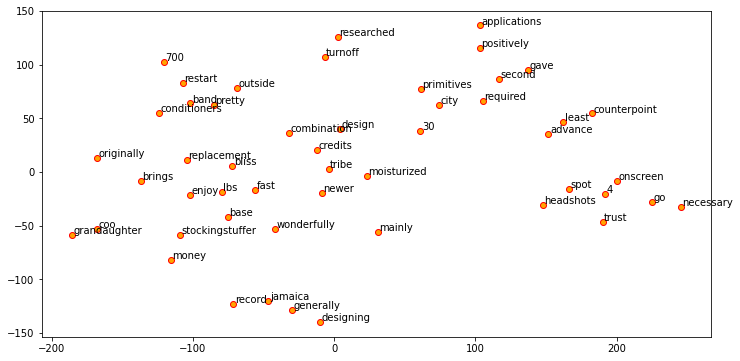

In [43]:
# visulization some doc using TSNE
tsne = TSNE(n_components=2, random_state=42, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(X_train_w2v_features_md_array[:50])
labels = list(set(word for subset in [doc.split() for doc in X_train_md[:50]] for word in subset))

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
plt.show()

In [233]:
# tokenize the md dataset
wpt = nltk.WordPunctTokenizer()

X_train_tokenized_corpus_pb = [wpt.tokenize(doc) for doc in X_train_pb]
X_test_tokenized_corpus_pb = [wpt.tokenize(doc) for doc in X_test_pb]

len(X_train_tokenized_corpus_pb), len(X_test_tokenized_corpus_pb)

(3495, 1499)

In [234]:
# train the word2vec model on PhaseBank dataset

feature_size = 200
window_context = 10
min_word_count = 0
sample = 1e-3

# texts = cleaned_multidomain_df.text.values
w2v_md = word2vec.Word2Vec(X_train_tokenized_corpus_pb, 
                           size=feature_size,
                           window=window_context,
                           min_count=min_word_count,
                           sample=sample,
                           iter=50)

In [235]:
# transform X_train_pb into vector, using vector average
X_train_w2v_features_pb_array = average_word_vectorizer(X_train_tokenized_corpus_pb, 
                                                        model=w2v_md, 
                                                        num_features=feature_size)

# transform X_test_pb into vector, using vector average
X_test_w2v_features_pb_array = average_word_vectorizer(X_test_tokenized_corpus_pb, 
                                                       model=w2v_md, 
                                                       num_features=feature_size)

X_train_w2v_features_pb_array.shape, X_test_w2v_features_pb_array.shape

/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


((3495, 200), (1499, 200))

<a id='glove'></a>
* Glove
> use pre-trained word vectors <br>
> Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download): glove.6B.zip

[back to table of contents](#toc)

In [236]:
glove_text_path = os.path.abspath('/Users/zz/Documents/data/ml/wikipedia2014_giga5_glove/glove.6B.200d.txt')

embedding_dict = {}
with open(glove_text_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector

In [237]:
len(embedding_dict)

400000

In [238]:
# calculate corpus vectors with glove and average 
def average_words_vectors_glove(tokenized_corpus, embedding_dict, num_features=feature_size):
    vocabulary = embedding_dict.keys()
    corpus_feature_vector = []

    for doc in tokenized_corpus:
        feature_vector = np.zeros((num_features,), dtype='float64')
        nwords = 0

        for word in doc:
            if word in vocabulary:
                nwords += 1
                feature_vector = np.add(feature_vector, embedding_dict[word])
        if doc and (nwords > 0):
            feature_vector = np.divide(feature_vector, nwords)
        corpus_feature_vector.append(feature_vector)
    return np.array(corpus_feature_vector)

In [50]:
X_train_glove_features_md_array = average_words_vectors_glove(X_train_tokenized_corpus_md,
                                                              embedding_dict)
X_test_glove_features_md_array = average_words_vectors_glove(X_test_tokenized_corpus_md,
                                                              embedding_dict)
X_train_glove_features_md_array.shape, X_test_glove_features_md_array.shape

((26980, 200), (11563, 200))

In [239]:
X_train_glove_features_pb_array = average_words_vectors_glove(X_train_tokenized_corpus_pb,
                                                              embedding_dict)
X_test_glove_features_pb_array = average_words_vectors_glove(X_test_tokenized_corpus_pb,
                                                             embedding_dict)

X_train_glove_features_pb_array.shape, X_test_glove_features_pb_array.shape

((3495, 200), (1499, 200))

<a id='elmo'></a>
* ELMo
> import the ELMo from tensorhub <br>
> 
[back to table of contents](#toc)

In [254]:
import tensorflow as tf
import tensorflow_hub as hub
import spacy
import pickle

# !python -m spacy download en_core_web_md

tf.__version__

'1.15.0'

In [241]:
import nltk
nltk.download('stopwords')

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /Users/zz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# get the dataset
# en_core_web_path = '/Users/zz/Documents/data/anaconda3/envs/tf2/lib/python3.8/site-packages/'
import en_core_web_md
nlp = en_core_web_md.load()

In [ ]:
# dataset for elmo 
cleaned_multidomain_df_elmo = pd.read_csv('multidomain_cleaned_with_spec_char.csv')
texts = cleaned_multidomain_df_elmo.text
target = cleaned_multidomain_df_elmo.target
total = len(texts)
counter = 0

clean_text = []
for line in texts:
    line = line.lower().replace('\n', ' ').replace('\t', ' ')
    line = ' '.join(line.split())
    doc = nlp(line)
    
    sentences = []
    for x in doc.sents:
        x = re.sub(r'[^a-zA-Z\s]', '', x.string.strip()).strip()
        if len(x)>1:
            sentences.append(x)

    clean_text.append(sentences)
    counter += 1
    if counter % 10000 == 0:
        print('[INFO] processed {} texts, {} in total.'.format(counter, total))

X_train_md_elmo, X_test_md_elmo, y_train_md_elmo, y_test_md_elmo = train_test_split(clean_text, 
                                                                target,
                                                                random_state=42,
                                                                test_size=0.3)
print(len(X_train_md_elmo), len(X_test_md_elmo))

In [ ]:
md_cleaned_with_spec_char = [X_train_md_elmo, X_test_md_elmo, y_train_md_elmo, y_test_md_elmo]

In [ ]:
# save the prosessed dataset into file
with open('md_cleaned_for_elmo.data', 'wb') as f:
    pickle.dump(md_cleaned_with_spec_char, f)

In [ ]:
# load the dataset
with open(base_path + 'md_cleaned_for_elmo.data', 'rb') as f:
    md_cleaned_for_elmo = pickle.load(f)
    
X_train_md_elmo = md_cleaned_for_elmo[0]
X_test_md_elmo = md_cleaned_for_elmo[1]
y_train_md_elmo = md_cleaned_for_elmo[2]
y_test_md_elmo = md_cleaned_for_elmo[3]

In [213]:
target.shape

(5717,)

In [245]:
# load phasbank dataset, and prepare for ELMo, preserve the special character
phasbank_dataset = pd.concat([phasbank_p100, phasbank_p75])

# ignore neutral classes
cleaned_phasbank_df_abs = phasbank_dataset.loc[phasbank_dataset.target != 0]
print(cleaned_phasbank_df_abs.shape)


texts = cleaned_phasbank_df_abs.text
target = cleaned_phasbank_df_abs.target
total = len(texts)

print(total)
cleaned_text = []
pattern = re.compile('(\smn\s)')

print('[INFO] start processing...')
for line in texts:
    line = line.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0', ' ').replace('%', 'percent')
    line = re.sub(pattern, ' millions ', line)
    line = ' '.join(line.split())
    doc = nlp(line)
    
    sentences = []
    for i in doc.sents:
        i = normalize_corpus(i.string, html_stripping=False)
        if len(i)>1:
            sentences.append(i)

    cleaned_text.append(sentences)
print('[INFO] finish processing..., total {} lines'.format(len(cleaned_text)))

X_train_pb_elmo, X_test_pb_elmo, y_train_pb_elmo, y_test_pb_elmo = train_test_split(texts, 
                                                                target,
                                                                random_state=42,
                                                                test_size=0.3)
print(X_train_pb_elmo.shape, X_test_pb_elmo.shape)

(4994, 2)
4994
[INFO] start processing...
[INFO] finish processing..., total 4994 lines
(3495,) (1499,)


In [247]:
phasbank_cleaned_for_elmo = [X_train_pb_elmo, X_test_pb_elmo, y_train_pb_elmo, y_test_pb_elmo]

In [248]:
import pickle

# save the prosessed dataset into file
with open('phasbank_cleaned_for_elmo.data', 'wb') as f:
    pickle.dump(phasbank_cleaned_for_elmo, f)


In [250]:
import pickle

with open('phasbank_cleaned_for_elmo.data', 'rb') as f:
    phasbank_cleaned_for_elmo = pickle.load(f)
    
X_train_pb_elmo = phasbank_cleaned_for_elmo[0].values
X_test_pb_elmo = phasbank_cleaned_for_elmo[1].values
y_train_pb_elmo = phasbank_cleaned_for_elmo[2].values
y_test_pb_elmo = phasbank_cleaned_for_elmo[3].values
print(X_train_pb_elmo.shape, X_test_pb_elmo.shape)

(3495,) (1499,)


In [255]:
url = "https://tfhub.dev/google/elmo/3"
embed = hub.Module(url)

RuntimeError: Missing implementation that supports: loader(*('/var/folders/g3/67sbxmn95vl7zxqzz_kqd0qw0000gn/T/tfhub_modules/58051eb9ff2f7c649b7c541acc518dac54e786ca',), **{})

In [ ]:
i = X_train_md_elmo[1]
embeddings = embed(i,
                   signature='default',
                   as_dict=True)['elmo']
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
#     y = sess.run(tf.reembeddings)
    x = sess.run(tf.reduce_mean(embeddings, (1, 0)))
x.shape

In [ ]:
with tf.Session() as sess:
    sess.run(tf.print(tf.squeeze(tf.cast(i, tf.string))))

In [ ]:
# process multidomain dataset using ELMo; train
total = len(X_train_md_elmo)
batch_size = total // 100
counter = 0

X_train_vec_elmo_md = []
for i in X_train_md_elmo:
    counter += 1
    embeddings = embed(i,
                       signature='default',
                       as_dict=True)['elmo']
    
    if counter % 10 == 0:
        print('[INFO] processing {}, total {}'.format(counter, total))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        x = sess.run(tf.reduce_mean(embeddings, (0, 1)))
    X_train_vec_elmo_md.append(x)

len(X_train_vec_elmo_md)

In [ ]:
# process multidomain dataset using ELMo; test
total = len(X_test_md_elmo)
batch_size = total // 50
counter = 0

X_test_vec_elmo_md = []
for i in X_test_md_elmo:
    counter += 1
    embeddings = embed(i,
                       signature='default',
                       as_dict=True)['elmo']
        
    if counter % 1000 == 0:
        print('[INFO] processing {}, total {}'.format(counter, total))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        x = sess.run(tf.reduce_mean(embeddings, (0, 1)))
    X_test_vec_elmo_md.append(x)

len(X_test_vec_elmo_md)

In [ ]:
# save the prosessed md_dataset into file

with open('X_train_vec_elmo_md.data', 'wb') as f:
    pickle.dump(X_train_vec_elmo_md, f)
    
with open('X_test_vec_elmo_md.data', 'wb') as f:
    pickle.dump(X_test_vec_elmo_md, f)

In [ ]:
# process phasebank dataset using ELMo; train

total = len(X_train_pb_elmo)
batch_size = total // 20
X_train_vec_elmo_pb = []

for i in range(0, total, batch_size):
    embeddings = embed(X_train_pb_elmo[i:min(i+batch_size, total)], 
                       signature='default', 
                       as_dict=True)['elmo']
    
    print('[INFO] processing {}, total {}'.format(i, total))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
#         x = sess.run(embeddings)
        x = sess.run(tf.reduce_mean(embeddings,1))
    X_train_vec_elmo_pb.extend(x)
    
len(X_train_pb_elmo)

In [53]:
import pickle

# save the prosessed dataset into file
with open('X_train_pb_elmo.data', 'wb') as f:
    pickle.dump(X_train_vec_elmo_pb, f)


NameError: name 'X_train_pb_elmo' is not defined

In [ ]:
# process phasebank dataset using ELMo; test
total = len(X_test_pb_elmo)
batch_size = total // 20
X_test_vec_elmo_pb = []


for i in range(0, total, batch_size):
    embeddings = embed(X_test_pb_elmo[i:min(i+batch_size, total)], 
                       signature='default', 
                       as_dict=True)['elmo']
 
    print('[INFO] processing {}, total {}'.format(i, total))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
#         x = sess.run(embeddings)
        x = sess.run(tf.reduce_mean(embeddings,1))
    X_test_vec_elmo_pb.extend(x)
    
len(X_test_vec_elmo_pb)

In [ ]:
import pickle

# save the prosessed dataset into file
with open('X_test_pb_elmo.data', 'wb') as f:
    pickle.dump(X_test_vec_elmo_pb, f)

In [270]:
import pickle

with open('X_train_pb_elmo.data', 'rb') as f:
    X_train_vec_elmo_pb = pickle.load(f)
with open('X_test_pb_elmo.data', 'rb') as f:
    X_test_vec_elmo_pb = pickle.load(f)

In [271]:
len(X_train_vec_elmo_pb), len(X_test_vec_elmo_pb)

(3495, 1499)

In [272]:
len(X_test_vec_elmo_pb[0]), len(X_train_vec_elmo_pb)

(1024, 3495)

<a id='classifier'></a>
## 7. Classifier

[back to table of contents](#toc)

<a id='classifier_trad'></a>
### 7.1 Traditional Classifier

* apply different algorithms to preprocessed embeddings
* bow <br> 
    * [X_train_vec_bow_md, X_test_vec_bow_md]
    * [X_train_vec_bi_md, X_test_vec_bi_md]
    * [X_train_vec_tri_md, X_test_vec_tri_md]
    * [X_train_vec_bow_pb, X_test_vec_bow_pb]
    * [X_train_vec_bi_pb, X_test_vec_bi_pb]
    * [X_train_vec_tri_pb, X_test_vec_tri_pb] <br>
* tfidf <br>
    * [X_train_vec_tfidf_md, X_test_vec_tfidf_md]
    * [X_train_vec_bi_tfidf_md, X_test_vec_bi_tfidf_md]
    * [X_train_vec_tfidf_pb, X_test_vec_tfidf_pb]
    * [X_train_vec_bi_tfidf_pb, X_test_vec_bi_tfidf_pb] <br>
* w2v <br>
    * [X_train_w2v_features_md_array, X_test_w2v_features_md_array]
    * [X_train_w2v_features_pb_array, X_test_w2v_features_pb_array] <br>
* glove <br>
    * [X_train_glove_features_md_array, X_test_glove_features_md_array]
    * [X_train_glove_features_pb_array, X_test_glove_features_pb_array] <br>
* elmo <br>
    * [X_train_vec_elmo_md, X_test_vec_elmo_md]
    * [X_train_vec_elmo_pb, X_test_vec_elmo_pb] <br>

[back to table of contents](#toc)

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
import os

%matplotlib inline

In [126]:
import tensorflow as tf
import tensorflow_hub as hub
import spacy
import pickle
import seaborn as sns

tf.__version__

'1.15.0'

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec
import nltk
from sklearn.manifold import TSNE

In [119]:
# load ml algorithms
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# evaluation metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [136]:
# plot the roc curve
# def plot_roc(model, X_test, y_test):
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate (recall)")
#     decision_function = model.decision_function(X_test)
#     fpr, tpr, _ = roc_curve(y_test, decision_function)
#     acc = model.score(X_test, y_test)
#     auc = roc_auc_score(y_test, model.decision_function(X_test))
#     plt.plot(fpr, tpr, label="acc:%.2f auc:%.2f" % (acc, auc), linewidth=3)
#     plt.legend(loc="best");

# # function to plot the roc curve given the false positive rate, true positive rate and the area under curve
# def plot_roc(fpr, tpr, roc_auc):
#     df_real = pd.DataFrame(fpr, columns=['false positive rate'])
#     df_real['true positive rate'] = pd.Series(tpr)
#     df_real['curve'] = 'model'
#     fpr_ideal = np.insert(fpr, 1, 0.00001)
#     df_ideal = pd.DataFrame(fpr_ideal, columns=['false positive rate'])
#     df_ideal['true positive rate'] = 1.0
#     df_ideal['true positive rate'][0] = 0.0
#     df_ideal['curve'] = 'ideal'
#     df_worst = pd.DataFrame(fpr, columns=['false positive rate'])
#     df_worst['true positive rate'] = pd.Series(fpr)
#     df_worst['curve'] = 'random guess'
#     df = pd.concat([df_real, df_ideal, df_worst])
#     pal = {'model': "#3498db", 'random guess':"#e74c3c", 'ideal':"#34495e"}
#     ax = sns.relplot('false positive rate', 'true positive rate', hue='curve', data=df,
#                 linewidth=2.0, palette=pal, kind="line", legend='full', height=5, aspect=7/5)
#     ax.set(xlim=(-.05, 1.0), ylim=(0.0, 1.05), title='Receiver operating characteristic\n(area under curve = %0.2f)' % roc_auc)
#     return

def plot_roc(result_table):
    fig = plt.figure(figsize=(8,6))

    for name, values in result_table.items():
        fpr = values[0]
        tpr = values[1]
        roc_auc = values[2]
        plt.plot(fpr, 
                 tpr, 
                 label="{}, AUC={:.3f}".format(name, roc_auc))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("Flase Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(prop={'size':13}, loc='lower right')

    plt.show()

In [262]:
def train_on_dataset(dataset, model, model_name, md=True):
    counter = 0
    roc_infor = dict()
    if md:
        datatset_selection = 'md'
    else:
        datatset_selection = 'pb'
        
    for name, dataset in dataset.items():
        counter += 1 
        if name.split('_')[-1] != datatset_selection:
            continue

        X_train = dataset[0]
        X_test = dataset[1]
        y_train = dataset[2]
        y_test = dataset[3]

        model.fit(X_train, y_train)
        model_pred = model.predict(X_test)

        print('No.{}: Apply {} model on dataset-{}:\n'.format(counter, model_name, name))
        print(classification_report(y_test, model_pred))
        print('accuracy score: {}'.format(accuracy_score(y_test, model_pred)))
        print('precision score: {}'.format(precision_score(y_test, model_pred)))
        print('recall score: {}'.format(recall_score(y_test, model_pred)))

        model_fpr, model_tpr, _ = roc_curve(y_test, model_pred)
        model_roc_auc = auc(model_fpr, model_tpr)
        roc_infor[name] = [model_fpr, model_tpr, model_roc_auc]

        print('***********************************************************')

    plot_roc(roc_infor)

In [273]:
# embedding dict 
text_embedding_dict = {'vec_bow_md': [X_train_vec_bow_md, X_test_vec_bow_md, y_train_md, y_test_md],
                       'vec_bi_md' : [X_train_vec_bi_md, X_test_vec_bi_md, y_train_md, y_test_md],
                       'vec_tri_md': [X_train_vec_tri_md, X_test_vec_tri_md, y_train_md, y_test_md],
                       'vec_tfidf_md': [X_train_vec_tfidf_md, X_test_vec_tfidf_md, y_train_md, y_test_md],
                       'vec_bi_tfidf_md': [X_train_vec_bi_tfidf_md, X_test_vec_bi_tfidf_md, y_train_md, y_test_md],
                       'vec_w2v_md': [X_train_w2v_features_md_array, X_test_w2v_features_md_array, y_train_md, y_test_md],
                       'vec_glv_md':[X_train_glove_features_md_array, X_test_glove_features_md_array, y_train_md, y_test_md],
                       'bec_bow_pb': [X_train_vec_bow_pb, X_test_vec_bow_pb, y_train_pb, y_test_pb],
                       'vec_bi_pb' : [X_train_vec_bi_pb, X_test_vec_bi_pb, y_train_pb, y_test_pb],
                       'vec_tri_pb': [X_train_vec_tri_pb, X_test_vec_tri_pb, y_train_pb, y_test_pb], 
                       'vec_tfidf_pb': [X_train_vec_tfidf_pb, X_test_vec_tfidf_pb, y_train_pb, y_test_pb],
                       'vec_bi_tfidf_pb': [X_train_vec_bi_tfidf_pb, X_test_vec_bi_tfidf_pb, y_train_pb, y_test_pb],
                       'vec_w2v_pb':[X_train_w2v_features_pb_array, X_test_w2v_features_pb_array, y_train_pb, y_test_pb],
                       'vec_glv_pb':[X_train_glove_features_pb_array, X_test_glove_features_pb_array, y_train_pb, y_test_pb],
                       'vec_elmo_pb':[X_train_vec_elmo_pb, X_test_vec_elmo_pb, y_train_pb, y_test_pb]
                      }

with open('text_embedding_dict.data', 'wb') as f:
    pickle.dump(text_embedding_dict, f)

In [274]:
with open('text_embedding_dict.data', 'rb') as f:
    text_embedding_dict = pickle.load(f)

In [277]:
len(text_embedding_dict['vec_elmo_pb'][0])

3495

<a id='bayes'></a>
* Bernoulli Naive Bayes<br> 
> using multidomain and PhaseBank dataset<br>
> generate 1-gram, bi-gram; ti-gram embeddings<br>

[back to table of contents](#toc)

No.1: Apply BernoulliNB model on dataset-vec_bow_md:

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      4902
           1       0.81      0.91      0.86      6661

    accuracy                           0.83     11563
   macro avg       0.83      0.81      0.82     11563
weighted avg       0.83      0.83      0.82     11563

accuracy score: 0.8253913344287814
precision score: 0.8093841642228738
recall score: 0.9115748386128208
***********************************************************
No.2: Apply BernoulliNB model on dataset-vec_bi_md:

              precision    recall  f1-score   support

           0       0.98      0.19      0.32      4902
           1       0.63      1.00      0.77      6661

    accuracy                           0.66     11563
   macro avg       0.80      0.60      0.55     11563
weighted avg       0.78      0.66      0.58     11563

accuracy score: 0.6563175646458531
precision score: 0.6268050967437471
reca

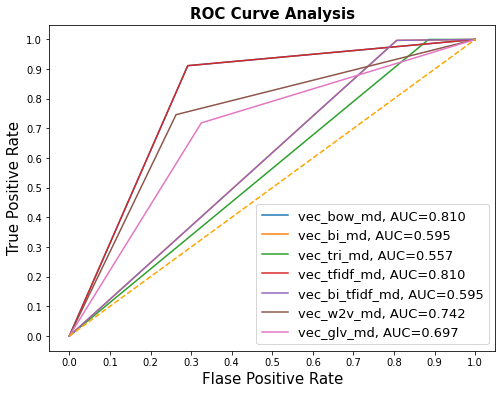

In [279]:
# using Multidomain dataset
nb = BernoulliNB()

train_on_dataset(text_embedding_dict, nb, 'BernoulliNB', 1)

No.8: Apply BernoulliNB model on dataset-bec_bow_pb:

              precision    recall  f1-score   support

          -1       0.90      0.96      0.93      1055
           1       0.88      0.76      0.82       444

    accuracy                           0.90      1499
   macro avg       0.89      0.86      0.87      1499
weighted avg       0.90      0.90      0.90      1499

accuracy score: 0.8985990660440294
precision score: 0.8802083333333334
recall score: 0.7612612612612613
***********************************************************
No.9: Apply BernoulliNB model on dataset-vec_bi_pb:

              precision    recall  f1-score   support

          -1       0.81      1.00      0.90      1055
           1       1.00      0.46      0.63       444

    accuracy                           0.84      1499
   macro avg       0.91      0.73      0.76      1499
weighted avg       0.87      0.84      0.82      1499

accuracy score: 0.8398932621747832
precision score: 1.0
recall score: 0.459

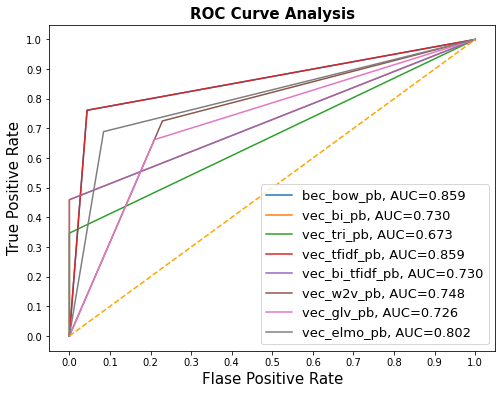

In [280]:
# using PhaseBank dataset
nb = BernoulliNB()
train_on_dataset(text_embedding_dict, nb, 'BernoulliNB', False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.801, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.802, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.798, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.798, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.800, total=   0.0s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ........................... alpha=0.1, score=0.824, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.821, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.812, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.818, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.817, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.809, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.809, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... alpha=0.01, score=0.776, total=   0.2s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.769, total=   0.1s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.760, total=   0.2s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.778, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.780, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.777, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.768, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.761, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.781, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.588, total=   0.2s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.574, total=   0.2s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.574, total=   0.2s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.577, total=   0.2s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.581, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.610, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.595, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.607, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.621, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    3.0s finished


No.3: Apply BernoulliNB model on dataset-vec_tri_md:

              precision    recall  f1-score   support

           0       0.89      0.42      0.57      4902
           1       0.69      0.96      0.80      6661

    accuracy                           0.73     11563
   macro avg       0.79      0.69      0.69     11563
weighted avg       0.78      0.73      0.71     11563

accuracy score: 0.7316440370146156
precision score: 0.6923243243243243
recall score: 0.9614172046239303
***********************************************************
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.801, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.802, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.800, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.824, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.821, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.812, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.818, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.817, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.809, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


recall score: 0.8702897462843416
***********************************************************
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.776, total=   0.1s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.769, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.760, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.778, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.780, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.777, total=   0.2s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.768, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.761, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


No.5: Apply BernoulliNB model on dataset-vec_bi_tfidf_md:

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      4902
           1       0.81      0.88      0.84      6661

    accuracy                           0.81     11563
   macro avg       0.81      0.80      0.80     11563
weighted avg       0.81      0.81      0.81     11563

accuracy score: 0.8091325780506788
precision score: 0.8066648306251721
recall score: 0.8794475304008407
***********************************************************
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.759, total=   0.1s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.746, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.726, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.752, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.749, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.759, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.746, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.726, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


No.6: Apply BernoulliNB model on dataset-vec_w2v_md:

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      4902
           1       0.79      0.75      0.77      6661

    accuracy                           0.74     11563
   macro avg       0.74      0.74      0.74     11563
weighted avg       0.75      0.74      0.74     11563

accuracy score: 0.7423678976044279
precision score: 0.7940894568690096
recall score: 0.7462843416904369
***********************************************************
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.693, total=   0.1s
[CV] alpha=0.01 ......................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.705, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.680, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.694, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.701, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.693, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.705, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.680, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.5s finished


No.7: Apply BernoulliNB model on dataset-vec_glv_md:

              precision    recall  f1-score   support

           0       0.64      0.67      0.66      4902
           1       0.75      0.72      0.73      6661

    accuracy                           0.70     11563
   macro avg       0.69      0.70      0.70     11563
weighted avg       0.70      0.70      0.70     11563

accuracy score: 0.7000778344720229
precision score: 0.7501958940604921
recall score: 0.7186608617324726
***********************************************************


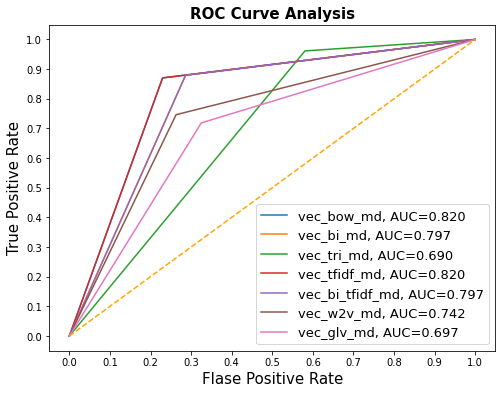

In [281]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha': [0.01, 0.1, 1]}

grid = GridSearchCV(BernoulliNB(), param_grid=param_grid, verbose=3)
train_on_dataset(text_embedding_dict, grid, 'BernoulliNB', 1)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.898, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.871, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.874, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.890, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.887, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.893, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.684, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.705, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.728, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.744, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.714, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.710, total=   0.0s
[CV] alpha=1 .........................................................
[CV] ............................. alpha=1, score=0.781, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ............................. alpha=1, score=0.834, total=   0.0s
No.12: Apply BernoulliNB model on dataset-vec_bi_tfidf_pb:

              precision    recall  f1-score   support

          -1       0.81      1.00      0.90      1055
           1       1.00      0.46      0.63       444

    accuracy                           0.84      1499
   macro avg       0.91      0.73      0.76      1499
weighted avg       0.87      0.84      0.82      1499

accuracy score: 0.8398932621747832
precision score: 1.0
recall score: 0.4594594594594595
***********************************************************
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.753, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.735, total=   0.0s
[CV] alpha=0.01 .................................

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


No.13: Apply BernoulliNB model on dataset-vec_w2v_pb:

              precision    recall  f1-score   support

          -1       0.87      0.77      0.82      1055
           1       0.57      0.73      0.64       444

    accuracy                           0.76      1499
   macro avg       0.72      0.75      0.73      1499
weighted avg       0.78      0.76      0.76      1499

accuracy score: 0.7571714476317545
precision score: 0.5709219858156028
recall score: 0.7252252252252253
***********************************************************
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.745, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.742, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .......................... alpha=0.01, score=0.844, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......................... alpha=0.01, score=0.811, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.814, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.818, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.845, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.844, total=   0.1s
[CV] alpha=0.1 .......................................................
[CV] ........................... alpha=0.1, score=0.811, total=   0.1s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.0s finished


No.15: Apply BernoulliNB model on dataset-vec_elmo_pb:

              precision    recall  f1-score   support

          -1       0.87      0.92      0.89      1055
           1       0.77      0.69      0.73       444

    accuracy                           0.85      1499
   macro avg       0.82      0.80      0.81      1499
weighted avg       0.84      0.85      0.85      1499

accuracy score: 0.847898599066044
precision score: 0.7741116751269036
recall score: 0.6869369369369369
***********************************************************


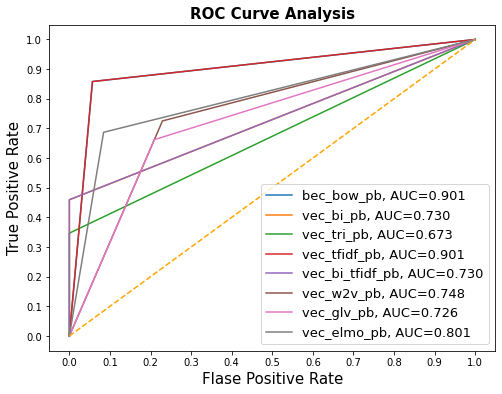

In [282]:
param_grid = {'alpha': [0.01, 0.1, 1]}

grid = GridSearchCV(BernoulliNB(), param_grid=param_grid, verbose=3)
train_on_dataset(text_embedding_dict, grid, 'BernoulliNB', 0)

<a id='lr'></a>
* Logistic Regression <br> 
> using lr classifier <br> 

    
    
[back to table of contents](#toc)



/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


No.1: Apply LogisticRegression model on dataset-vec_bow_md:

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4902
           1       0.88      0.88      0.88      6661

    accuracy                           0.86     11563
   macro avg       0.86      0.86      0.86     11563
weighted avg       0.86      0.86      0.86     11563

accuracy score: 0.8595520193721352
precision score: 0.8765136791747645
recall score: 0.8801981684431767
***********************************************************
No.2: Apply LogisticRegression model on dataset-vec_bi_md:

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      4902
           1       0.81      0.91      0.86      6661

    accuracy                           0.82     11563
   macro avg       0.83      0.81      0.81     11563
weighted avg       0.83      0.82      0.82     11563

accuracy score: 0.824180575975093
precision score: 0.80779462

/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


No.7: Apply LogisticRegression model on dataset-vec_glv_md:

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      4902
           1       0.81      0.83      0.82      6661

    accuracy                           0.79     11563
   macro avg       0.78      0.78      0.78     11563
weighted avg       0.79      0.79      0.79     11563

accuracy score: 0.7875118913776702
precision score: 0.808482535955386
recall score: 0.8270529950457889
***********************************************************


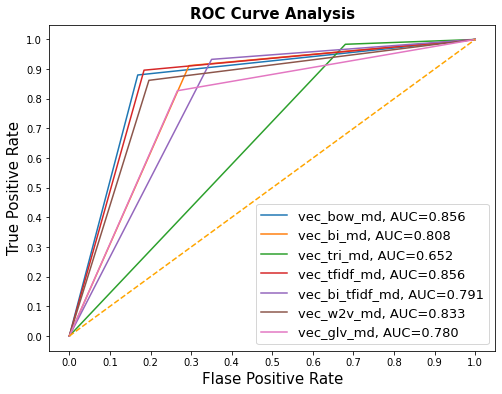

In [283]:
lr = LogisticRegression()
train_on_dataset(text_embedding_dict, lr, 'LogisticRegression', 1)

No.8: Apply LogisticRegression model on dataset-bec_bow_pb:

              precision    recall  f1-score   support

          -1       0.93      0.99      0.96      1055
           1       0.97      0.83      0.89       444

    accuracy                           0.94      1499
   macro avg       0.95      0.91      0.93      1499
weighted avg       0.94      0.94      0.94      1499

accuracy score: 0.9419613075383589
precision score: 0.9709762532981531
recall score: 0.8288288288288288
***********************************************************
No.9: Apply LogisticRegression model on dataset-vec_bi_pb:

              precision    recall  f1-score   support

          -1       0.89      1.00      0.94      1055
           1       0.98      0.70      0.82       444

    accuracy                           0.91      1499
   macro avg       0.94      0.85      0.88      1499
weighted avg       0.92      0.91      0.90      1499

accuracy score: 0.9092728485657104
precision score: 0.9842767

/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

No.15: Apply LogisticRegression model on dataset-vec_elmo_pb:

              precision    recall  f1-score   support

          -1       0.97      0.98      0.98      1055
           1       0.96      0.93      0.94       444

    accuracy                           0.97      1499
   macro avg       0.96      0.96      0.96      1499
weighted avg       0.97      0.97      0.97      1499

accuracy score: 0.9666444296197465
precision score: 0.9560185185185185
recall score: 0.9301801801801802
***********************************************************


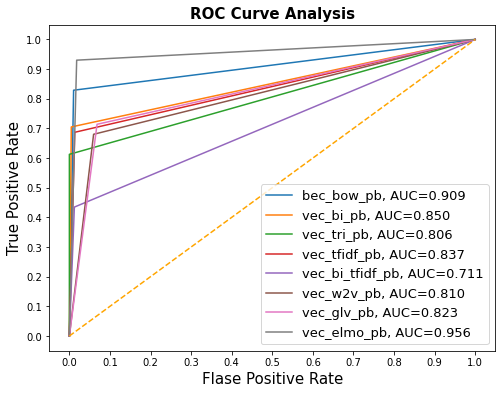

In [284]:
lr = LogisticRegression()
train_on_dataset(text_embedding_dict, lr, 'LogisticRegression', 0)

/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


No.1: Apply lr model on dataset-vec_bow_md:

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      4902
           1       0.88      0.88      0.88      6661

    accuracy                           0.86     11563
   macro avg       0.86      0.86      0.86     11563
weighted avg       0.86      0.86      0.86     11563

accuracy score: 0.8595520193721352
precision score: 0.8765136791747645
recall score: 0.8801981684431767
***********************************************************
No.2: Apply lr model on dataset-vec_bi_md:

              precision    recall  f1-score   support

           0       0.85      0.71      0.77      4902
           1       0.81      0.91      0.86      6661

    accuracy                           0.82     11563
   macro avg       0.83      0.81      0.81     11563
weighted avg       0.83      0.82      0.82     11563

accuracy score: 0.824180575975093
precision score: 0.8077946262303805
recall score: 0.9117249

/Users/zz/Documents/data/anaconda3/envs/tf1/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


No.7: Apply lr model on dataset-vec_glv_md:

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      4902
           1       0.81      0.83      0.82      6661

    accuracy                           0.79     11563
   macro avg       0.78      0.78      0.78     11563
weighted avg       0.79      0.79      0.79     11563

accuracy score: 0.7875118913776702
precision score: 0.808482535955386
recall score: 0.8270529950457889
***********************************************************


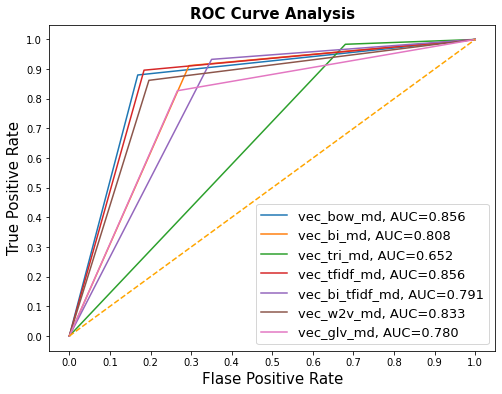

In [291]:
counter = 0
roc_infor = dict()
model_name = 'lr'


for name, dataset in text_embedding_dict.items():
    counter += 1 
    model = LogisticRegression()
    if name.split('_')[-1] != 'md':
        continue

    X_train = dataset[0]
    X_test = dataset[1]
    y_train = dataset[2]
    y_test = dataset[3]

    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)

    print('No.{}: Apply {} model on dataset-{}:\n'.format(counter, model_name, name))
    print(classification_report(y_test, model_pred))
    print('accuracy score: {}'.format(accuracy_score(y_test, model_pred)))
    print('precision score: {}'.format(precision_score(y_test, model_pred)))
    print('recall score: {}'.format(recall_score(y_test, model_pred)))

    model_fpr, model_tpr, _ = roc_curve(y_test, model_pred)
    model_roc_auc = auc(model_fpr, model_tpr)
    roc_infor[name] = [model_fpr, model_tpr, model_roc_auc]

    print('***********************************************************')

plot_roc(roc_infor)

<a id='svm'></a>
* Support Vector Machine 
> 
> 

[back to table of contents](#toc)

No.1: Apply LogisticRegression model on dataset-vec_bow_md:

              precision    recall  f1-score   support

           0       0.85      0.76      0.81      4902
           1       0.84      0.90      0.87      6661

    accuracy                           0.84     11563
   macro avg       0.85      0.83      0.84     11563
weighted avg       0.84      0.84      0.84     11563

accuracy score: 0.8438121594741849
precision score: 0.8381390165761248
recall score: 0.903317820147125
***********************************************************
No.2: Apply LogisticRegression model on dataset-vec_bi_md:

              precision    recall  f1-score   support

           0       0.87      0.48      0.62      4902
           1       0.71      0.95      0.81      6661

    accuracy                           0.75     11563
   macro avg       0.79      0.71      0.71     11563
weighted avg       0.78      0.75      0.73     11563

accuracy score: 0.7485081726195624
precision score: 0.71148427

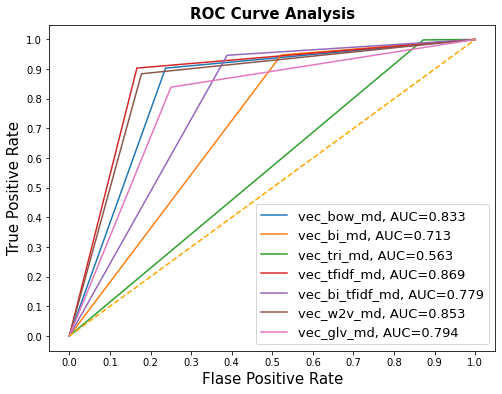

In [287]:
svm = SVC()
train_on_dataset(text_embedding_dict, svm, 'svm', 1)

No.8: Apply LogisticRegression model on dataset-bec_bow_pb:

              precision    recall  f1-score   support

          -1       0.91      0.99      0.95      1055
           1       0.98      0.76      0.86       444

    accuracy                           0.92      1499
   macro avg       0.94      0.88      0.90      1499
weighted avg       0.93      0.92      0.92      1499

accuracy score: 0.9246164109406271
precision score: 0.9825072886297376
recall score: 0.759009009009009
***********************************************************
No.9: Apply LogisticRegression model on dataset-vec_bi_pb:

              precision    recall  f1-score   support

          -1       0.87      0.99      0.93      1055
           1       0.98      0.65      0.78       444

    accuracy                           0.89      1499
   macro avg       0.93      0.82      0.85      1499
weighted avg       0.90      0.89      0.88      1499

accuracy score: 0.8919279519679787
precision score: 0.97959183

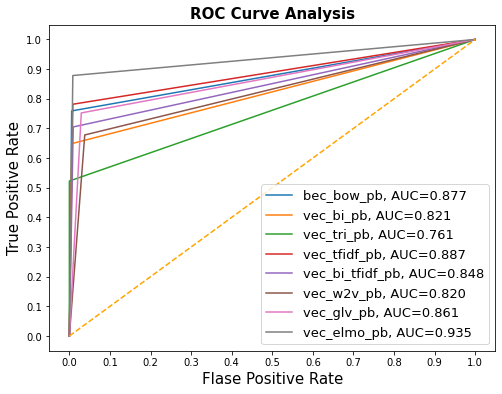

In [288]:
svm = SVC()
train_on_dataset(text_embedding_dict, svm, 'svm', 0)

<a id='classifier_dl'></a>
### 7.2 DL Classifier

refer to "sa_dl_approach" file

[back to table of contents](#toc)